<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Bidirectional

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
df_reviews.rename(columns={'Review Text': 'review_text', 'Rating': 'rating'}, inplace=True)

In [7]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

In [8]:
# Cantidad absoluta de muestras para cada clase
df_reviews['rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: rating, dtype: int64

In [9]:
# Cantidad relativa de muestras para cada clase
df_reviews['rating'].value_counts(normalize=True)

4    0.553862
3    0.216775
2    0.124685
1    0.068416
0    0.036262
Name: rating, dtype: float64

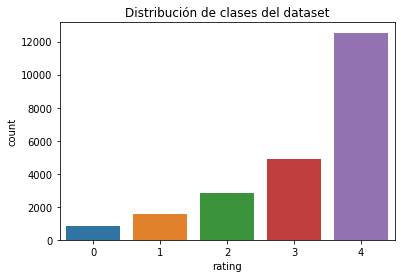

In [10]:
# Observar como está distribuido el dataset
ax = sns.countplot(x='rating', data=df_reviews)
ax.set_title('Distribución de clases del dataset')
plt.show()

- Se puede observar que el dataset se encuentra desbalanceado, posteriormente procederemos a aplicar una técnica para revertir esta situación.

In [11]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['review_text'].values
text_sequences.shape

(22641,)

In [12]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [13]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [14]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [15]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [16]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [17]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [18]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [19]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [20]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [21]:
sequences[0][:10]

[253, 532, 917, 3, 662, 3, 68]

In [22]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

115

In [23]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.preprocessing.sequence import pad_sequences
maxlen = 115

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [24]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 115)

In [25]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = pd.get_dummies(df_reviews['rating'])
print(y.shape)

(22641, 5)


In [26]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
print(f'Shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}')

Shapes: X_train=(18112, 115), X_test=(4529, 115), y_train=(18112, 5), y_test=(4529, 5)


### 1.1 Oversampling para el balance de clases

In [28]:
# Se aplica la técnica de oversampling para balancear las clases
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy='auto');

X_train_os,y_train_os=oversampler.fit_resample(X_train, y_train.to_numpy());

print('Composición del training set:')
print(pd.DataFrame(y_train_os).value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
0  1  2  3  4
0  0  0  0  1    9995
         1  0    9995
      1  0  0    9995
   1  0  0  0    9995
1  0  0  0  0    9995
dtype: int64

Composición del test set:
0  1  2  3  4
0  0  0  0  1    2545
         1  0     939
      1  0  0     588
   1  0  0  0     309
1  0  0  0  0     148
dtype: int64


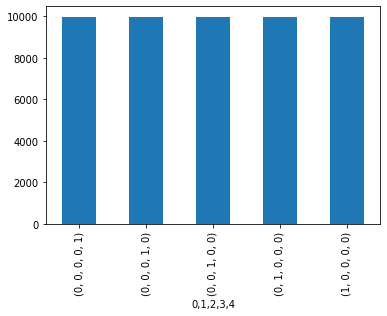

In [29]:
pd.DataFrame(y_train_os).value_counts().plot.bar('Clases balanceadas')

In [30]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # categorical classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [31]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 50)           100050    
                                                                 
 lstm (LSTM)                 (None, 115, 128)          91648     
                                                                 
 dropout (Dropout)           (None, 115, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1

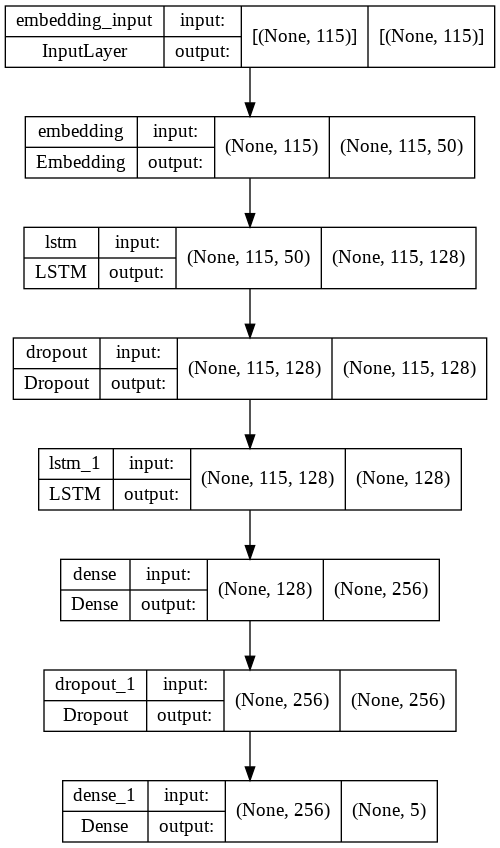

In [32]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [33]:
hist = model.fit(X_train_os, y_train_os, epochs=15, validation_split=0.2)

Epoch 1/15
1250/1250 [==============================] - 33s 19ms/step - loss: 0.9881 - accuracy: 0.5988 - val_loss: 1.6573 - val_accuracy: 0.1149
Epoch 2/15
1250/1250 [==============================] - 22s 18ms/step - loss: 0.6180 - accuracy: 0.7678 - val_loss: 1.5230 - val_accuracy: 0.2390
Epoch 3/15
1250/1250 [==============================] - 22s 18ms/step - loss: 0.4846 - accuracy: 0.8199 - val_loss: 1.2088 - val_accuracy: 0.3586
Epoch 4/15
1250/1250 [==============================] - 23s 18ms/step - loss: 0.4084 - accuracy: 0.8462 - val_loss: 1.1527 - val_accuracy: 0.3512
Epoch 5/15
1250/1250 [==============================] - 23s 19ms/step - loss: 0.3651 - accuracy: 0.8617 - val_loss: 1.0658 - val_accuracy: 0.3953
Epoch 6/15
1250/1250 [==============================] - 23s 18ms/step - loss: 0.3344 - accuracy: 0.8710 - val_loss: 0.9979 - val_accuracy: 0.4705
Epoch 7/15
1250/1250 [==============================] - 22s 18ms/step - loss: 0.3101 - accuracy: 0.8801 - val_loss: 0.9425 -

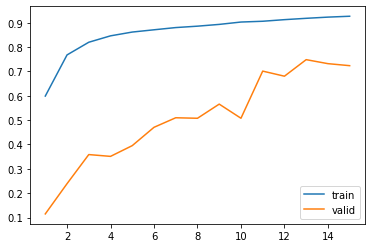

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [35]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 2s 8ms/step - loss: 2.0443 - accuracy: 0.6057


[2.0443480014801025, 0.6056524515151978]

### 3 - Entrenar el modelo con Embeddings Fasttext + LSTM

In [36]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Los embeddings fasttext.pkl ya están descargados


In [37]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [38]:
model_fasttext = FasttextEmbeddings()

In [39]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', len(words_not_found))

preparing embedding matrix...
number of null word embeddings: 0


In [40]:
model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model2.add(LSTM(units=128, return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(units=128)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=256, activation='relu'))
model2.add(Dropout(rate=0.3))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_2 (LSTM)               (None, 115, 128)          219648    
                                                                 
 dropout_2 (Dropout)         (None, 115, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                

In [41]:
hist2 = model2.fit(X_train_os, y_train_os, epochs=15, validation_split=0.2)

Epoch 1/15
1250/1250 [==============================] - 25s 18ms/step - loss: 1.4671 - accuracy: 0.3599 - val_loss: 2.1199 - val_accuracy: 0.0000e+00
Epoch 2/15
1250/1250 [==============================] - 21s 17ms/step - loss: 1.1803 - accuracy: 0.5345 - val_loss: 1.7997 - val_accuracy: 0.0543
Epoch 3/15
1250/1250 [==============================] - 22s 17ms/step - loss: 0.7687 - accuracy: 0.7068 - val_loss: 1.5361 - val_accuracy: 0.1834
Epoch 4/15
1250/1250 [==============================] - 22s 17ms/step - loss: 0.5741 - accuracy: 0.7798 - val_loss: 1.3063 - val_accuracy: 0.2843
Epoch 5/15
1250/1250 [==============================] - 21s 17ms/step - loss: 0.4814 - accuracy: 0.8131 - val_loss: 1.1198 - val_accuracy: 0.3519
Epoch 6/15
1250/1250 [==============================] - 21s 17ms/step - loss: 0.4247 - accuracy: 0.8339 - val_loss: 1.1286 - val_accuracy: 0.3800
Epoch 7/15
1250/1250 [==============================] - 21s 17ms/step - loss: 0.3838 - accuracy: 0.8476 - val_loss: 0.93

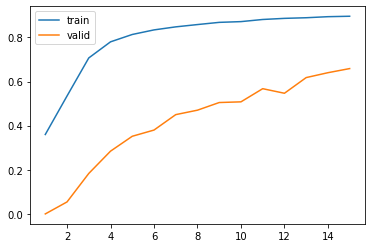

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [43]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 2s 8ms/step - loss: 2.2322 - accuracy: 0.5363


[2.2322139739990234, 0.5363214612007141]

### 4 - Conclusión

Es posible notar que el modelo que utiliza embeddings pre-entrenados obtiene un valor más bajo para la métrica Accuracy, tanto en el conjunto de validación como en el de testeo. No obstante, se puede observar en la gráfica que la métrica podría continuar creciendo por lo que es posible que aumentando el número de épocas y/o incrementando la complejidad del modelo se obtengan mejores resultados empleando embeddings pre-entrenados que sin ellos.

Sin embargo, en este ejercicio, optamos por seleccionar al modelo sin embeddings pre-entrenados como favorito debido a que obtuvo mejores resultados.